In [205]:
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(gprofiler2)
library(ComplexHeatmap)
library(circlize)

In [206]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/July2021/"
myfiles = list.files(mydir,"corrs")

In [207]:
myfiles

[1] "corrs_cluster0.csv"  "corrs_cluster1.csv"  "corrs_cluster10.csv"
 [4] "corrs_cluster11.csv" "corrs_cluster2.csv"  "corrs_cluster3.csv" 
 [7] "corrs_cluster4.csv"  "corrs_cluster5.csv"  "corrs_cluster6.csv" 
[10] "corrs_cluster7.csv"  "corrs_cluster8.csv"  "corrs_cluster9.csv" 
[13] "old_corrs"

In [391]:
myfiles = c("corrs_cluster5.csv", "corrs_cluster2.csv","corrs_cluster4.csv","corrs_cluster9.csv",
            "corrs_cluster10.csv","corrs_cluster8.csv", "old_corrs")

In [431]:
myfiles = c("corrs_cluster4.csv","old_corrs")

In [432]:
df0 = read.csv(paste0(mydir,myfiles[1]),row.names=1)
head(df0,2)

,gene,corr_cluster4
MT.ND1,MT.ND1,0.6173968
EIF5,EIF5,0.6063482


In [433]:
df = df0
# for (i in 2:(length(myfiles)-1)){
#     df0 = read.csv(paste0(mydir,myfiles[i]),row.names = 1)
#     df = inner_join(df,df0,by="gene")
# }
# df

In [434]:
rownames(df) = df$gene
df$gene = c()

In [435]:
head(df)

,corr_cluster4
MT.ND1,0.6173968
EIF5,0.6063482
MT.ND2,0.5978876
SFPQ,0.5972742
PDCD5,0.5970141
FBXO9,0.5843701


In [436]:
# write.csv(df, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/July2021/gene_cluster_correlations.csv", quote=F)

In [437]:
########### Genes positively correlated with cluster summary profiles

In [438]:
# df = df[,c("corr_cluster5", "corr_cluster2","corr_cluster4","corr_cluster9","corr_cluster10","corr_cluster8")]
# df = df[,c("corr_cluster5","corr_cluster4")]
# df = as.data.frame(df[,c("corr_cluster5")])

In [449]:
df_list = list()
for (i in 1:ncol(df)){
    gene_list = df[,i]
    names(gene_list) = rownames(df)
    # get positively correlated genes
    genes_pos = gene_list[gene_list>0.4]
#     genes_pos = gene_list
    if (length(genes_pos)==0){next}
    # order
    genes_pos = genes_pos[order(genes_pos, decreasing = T)]
    # get gene names only
    genes = gsub(".*_","",names(genes_pos))
    # run gprofiler
    gres = gost(query=genes, organism = "hsapiens", ordered_query = TRUE, significant=FALSE, source = "GO:CC")
    df_list[[i]] = as.data.frame(gres$result)
}

In [450]:
# ?gost

In [459]:
pats = c()
for (i in 1:length(df_list)){
    if (is.null(df_list[[i]])){next}
    df_curr = as.data.frame(df_list[[i]])
    df_curr = df_curr[df_curr$p_value < 0.05,]
#     print(nrow(df_curr))
    n = min(10, nrow(df_curr))
    pats = c(pats, unique(df_curr[1:n,"term_name"]))
}

In [460]:
# pats = c("response to oxidative stress","apoptotic signaling pathway","regulation of cell death", # cluster 5
#         "protein localization to endoplasmic reticulum","protein targeting","translation", # cluster 2
#         "cytoplasm","neuron projection","intracellular anatomical structure", # cluster 4
#         "synaptic signaling","exocytosis","neurotransmitter secretion", # cluster 9
#         "developmental process","exocytosis","tissue development", # cluster 10
#         "Parkinson disease","microtubule","Gap junction") # cluster 8

In [461]:
length(pats)
pats

[1] 10

[1] "cytoplasm"                              
 [2] "neuron projection"                      
 [3] "intracellular anatomical structure"     
 [4] "somatodendritic compartment"            
 [5] "synapse"                                
 [6] "dendrite"                               
 [7] "dendritic tree"                         
 [8] "axon"                                   
 [9] "plasma membrane bounded cell projection"
[10] "cell projection"

In [462]:
df_to_plot = data.frame()
for (i in 1:length(df_list)){
#     print(i)
    cluster = gsub("corr_","",colnames(df)[i])
    df_curr = df_list[[i]]
    
    if (is.null(df_curr)){next}
    df_curr$cluster = cluster
    df_to_plot = rbind(df_to_plot, df_curr[df_curr$term_name %in% pats,
                                           c("p_value","cluster","term_name","term_id")])
}

In [463]:
# unique(df_to_plot$cluster)
# df_to_plot$cluster <- factor(df_to_plot$cluster, 
#                              levels = c("cluster5", "cluster2","cluster4",
#                                         "cluster9","cluster10","cluster8"))
# #                                         , "cluster4", "cluster5", "cluster8",
# #                                         "cluster9", "cluster11", "cluster2", "cluster10", "cluster3", 
# #                                         "cluster6", "cluster7", "cluster4"))

In [464]:
unique(df_to_plot$cluster)
df_to_plot$cluster <- factor(df_to_plot$cluster, 
                             levels = c("cluster9", "cluster4","cluster5",
                                        "cluster10","cluster8","cluster2"))
#                                         , "cluster4", "cluster5", "cluster8",
#                                         "cluster9", "cluster11", "cluster2", "cluster10", "cluster3", 
#                                         "cluster6", "cluster7", "cluster4"))

[1] "cluster4"

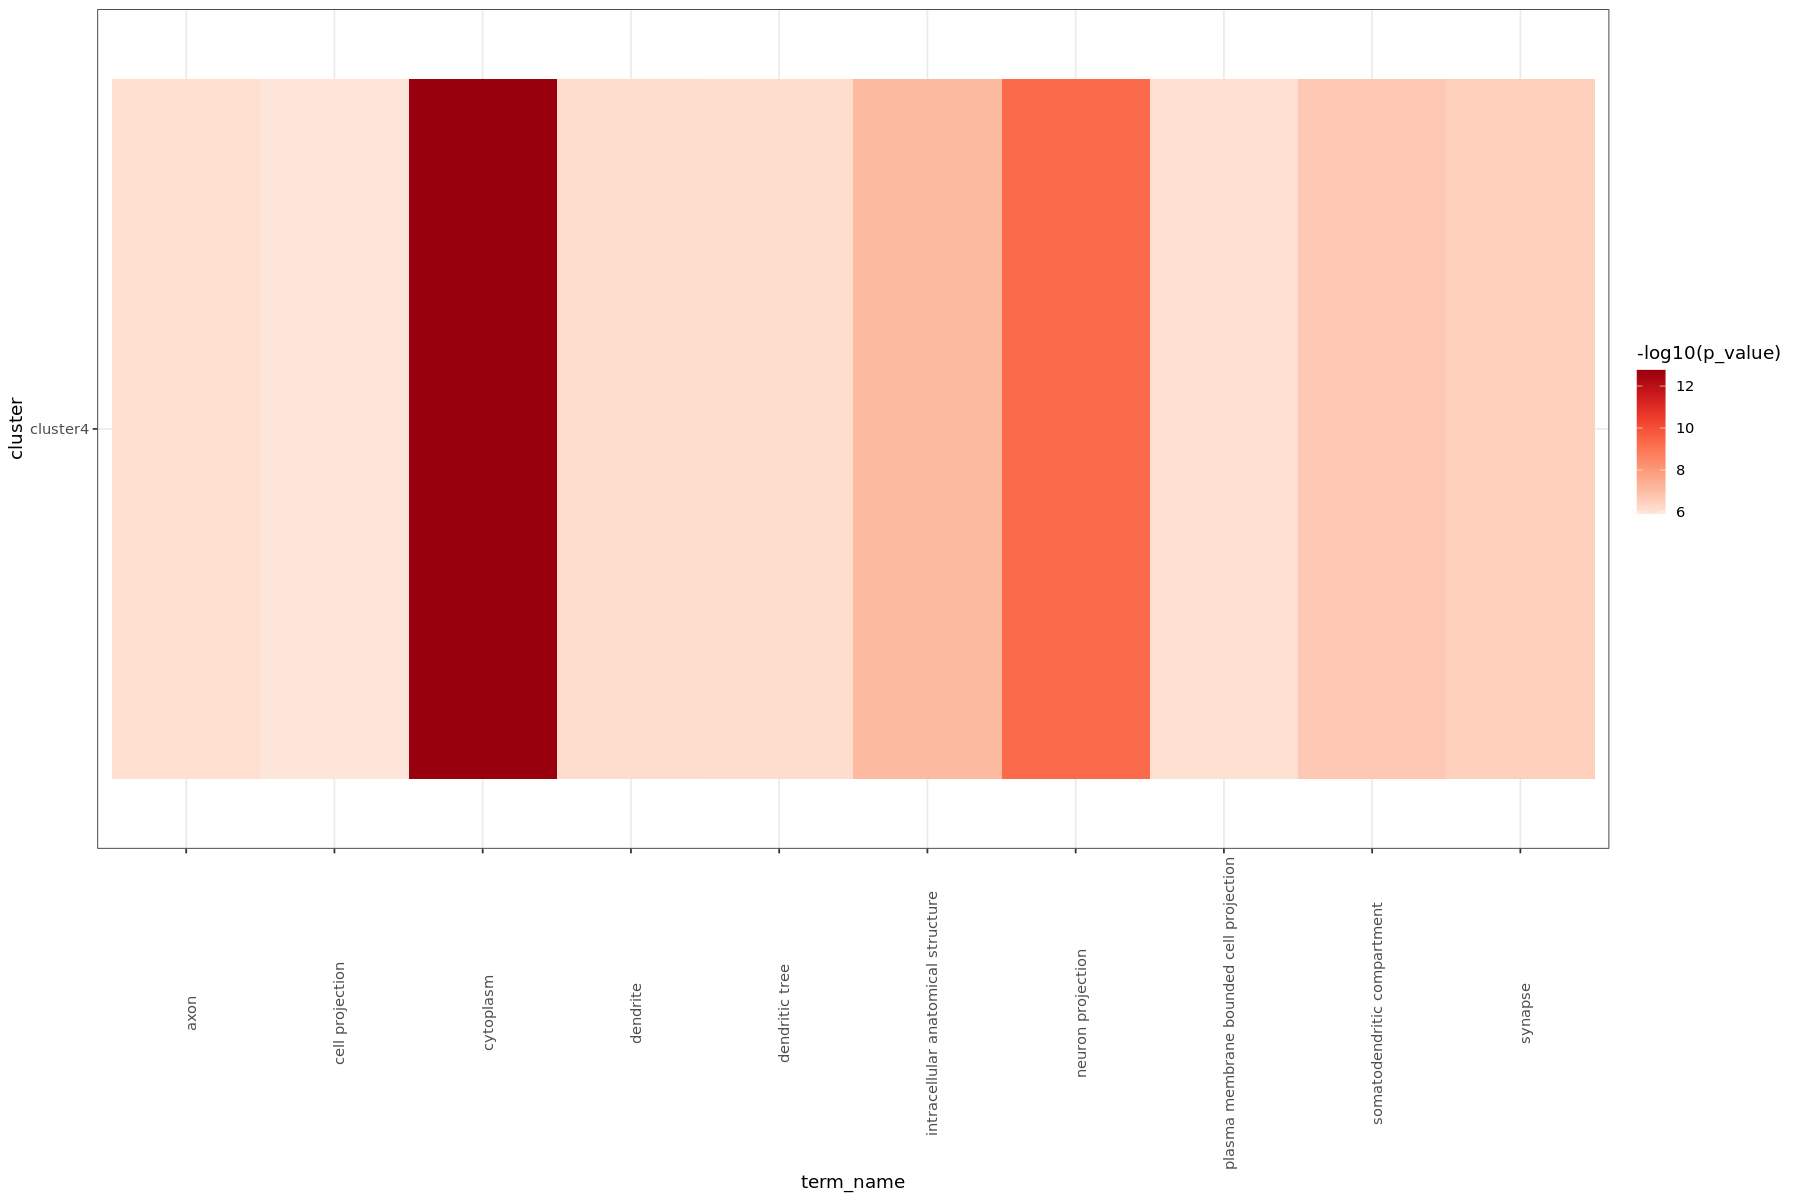

In [465]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(df_to_plot, aes(x=term_name, y=cluster, fill = -log10(p_value))) + geom_tile() + 
    theme_bw() + theme(axis.text.x = element_text(angle = 90)) + 
    scale_fill_gradientn(colors = brewer.pal(7,"Reds"))

In [468]:
df_to_plot$term_name

[1] "cytoplasm"                              
 [2] "neuron projection"                      
 [3] "intracellular anatomical structure"     
 [4] "somatodendritic compartment"            
 [5] "synapse"                                
 [6] "dendrite"                               
 [7] "dendritic tree"                         
 [8] "axon"                                   
 [9] "plasma membrane bounded cell projection"
[10] "cell projection"

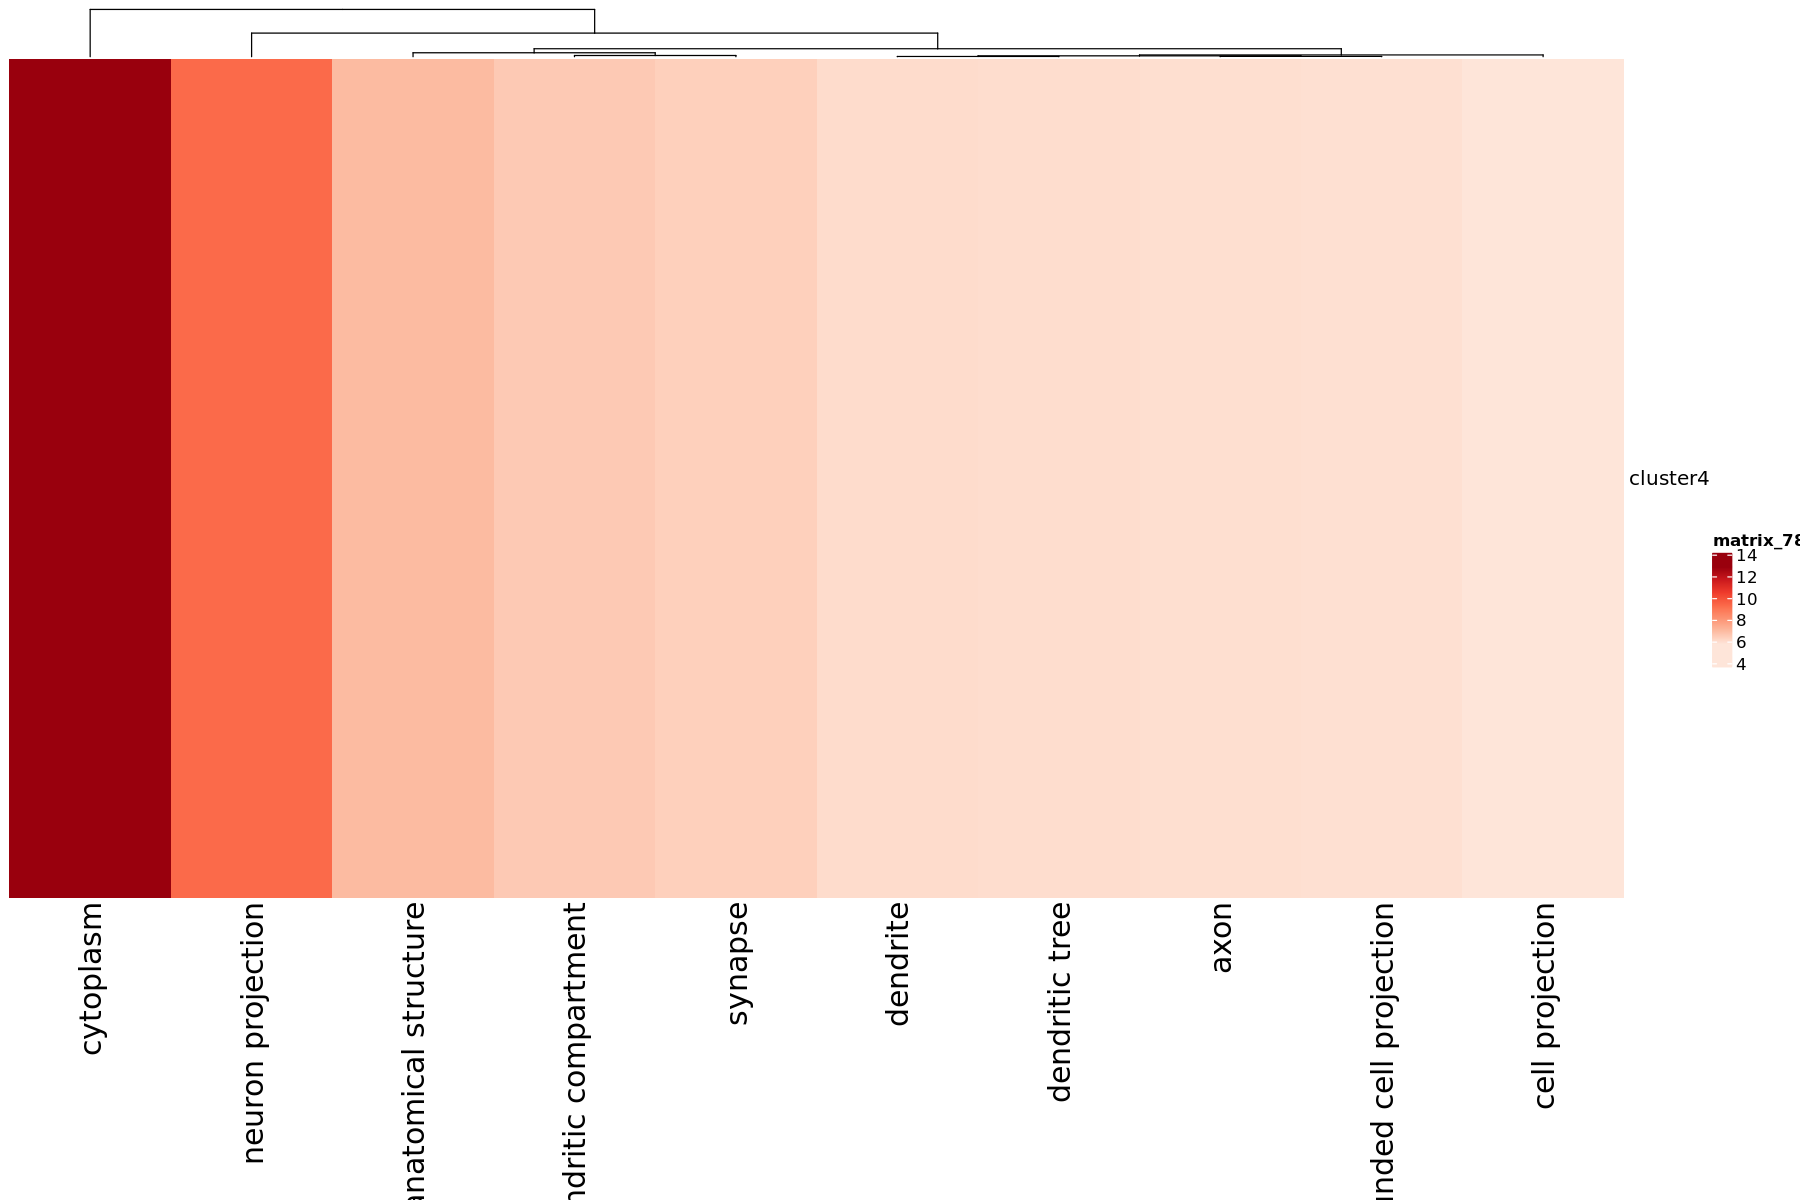

In [467]:
# df_to_plot = df_to_plot[df_to_plot$term_name != "cytoplasm",]
df_to_plot$cluster = as.character(df_to_plot$cluster)
df_to_plot$term_name = as.character(df_to_plot$term_name)
mat = matrix(0, nrow=length(unique(df_to_plot$cluster)), ncol=length(unique(df_to_plot$term_name)))
for (i in 1:nrow(mat)){
    cluster = unique(df_to_plot$cluster)[i]
    for (j in 1:ncol(mat)){
        term = unique(df_to_plot$term_name)[j]
#         print(term)
        if (length(df_to_plot[df_to_plot$cluster == cluster & df_to_plot$term_name == term,"p_value"]) == 0){next}
        mat[i,j] = min(df_to_plot[df_to_plot$cluster == cluster & df_to_plot$term_name == term,"p_value"])
    }
}
rownames(mat) = unique(df_to_plot$cluster)
colnames(mat) = unique(df_to_plot$term_name)
# mat = mat[c("cluster9", "cluster4","cluster5","cluster10","cluster8","cluster2"),]
mat0 = -log10(mat)
mat0[mat0==Inf] = -1
Heatmap(mat0, 
        col = brewer.pal(7,"Reds"),
#         col = colorRamp2(c(0,5,10,20), c("grey95","tomato","firebrick","darkred")), 
        cluster_rows = F, 
        column_names_gp = grid::gpar(fontsize = 18))

In [359]:
########### Genes negatively correlated with cluster summary profiles

In [85]:
df_list = list()
for (i in 1:ncol(df)){
    gene_list = df[,i]
    names(gene_list) = rownames(df)
#     print(head(gene_list))
    # get negatively correlated genes
    genes_neg = gene_list[gene_list<(-0.4)]
    if (length(genes_neg)==0){next}
    # order
    genes_neg = genes_neg[order(genes_neg)]
    # get gene names only
    genes = gsub(".*_","",names(genes_neg))
    # run gprofiler
    gres = gost(query=genes, organism = "hsapiens", ordered_query = TRUE, significant=FALSE, source = "GO:CC")
    df_list[[i]] = as.data.frame(gres$result)
}

In [86]:
pats = c()
for (i in 1:length(df_list)){
    if (is.null(df_list[[i]])){next}
    df_curr = as.data.frame(df_list[[i]])
    df_curr = df_curr[df_curr$p_value < 0.05,]
#     print(nrow(df_curr))
    n = min(10, nrow(df_curr))
    pats = c(pats, unique(df_curr[1:n,"term_name"]))
}
length(pats)

[1] 6

In [87]:
df_to_plot = data.frame()
for (i in 1:length(df_list)){
#     print(i)
    cluster = gsub("corr_","",colnames(df)[i])
    df_curr = df_list[[i]]
    
    if (is.null(df_curr)){next}
    df_curr$cluster = cluster
    df_to_plot = rbind(df_to_plot, df_curr[df_curr$term_name %in% pats,
                                           c("p_value","cluster","term_name","term_id")])
}
unique(df_to_plot$cluster)
# df_to_plot$cluster <- factor(df_to_plot$cluster, 
#                              levels = c("cluster12", "cluster0", "cluster1", "cluster5", "cluster8",
#                                         "cluster9", "cluster11", "cluster2", "cluster10", "cluster3",
#                                         "cluster6", "cluster7", "cluster4"))

[1] "cluster4"

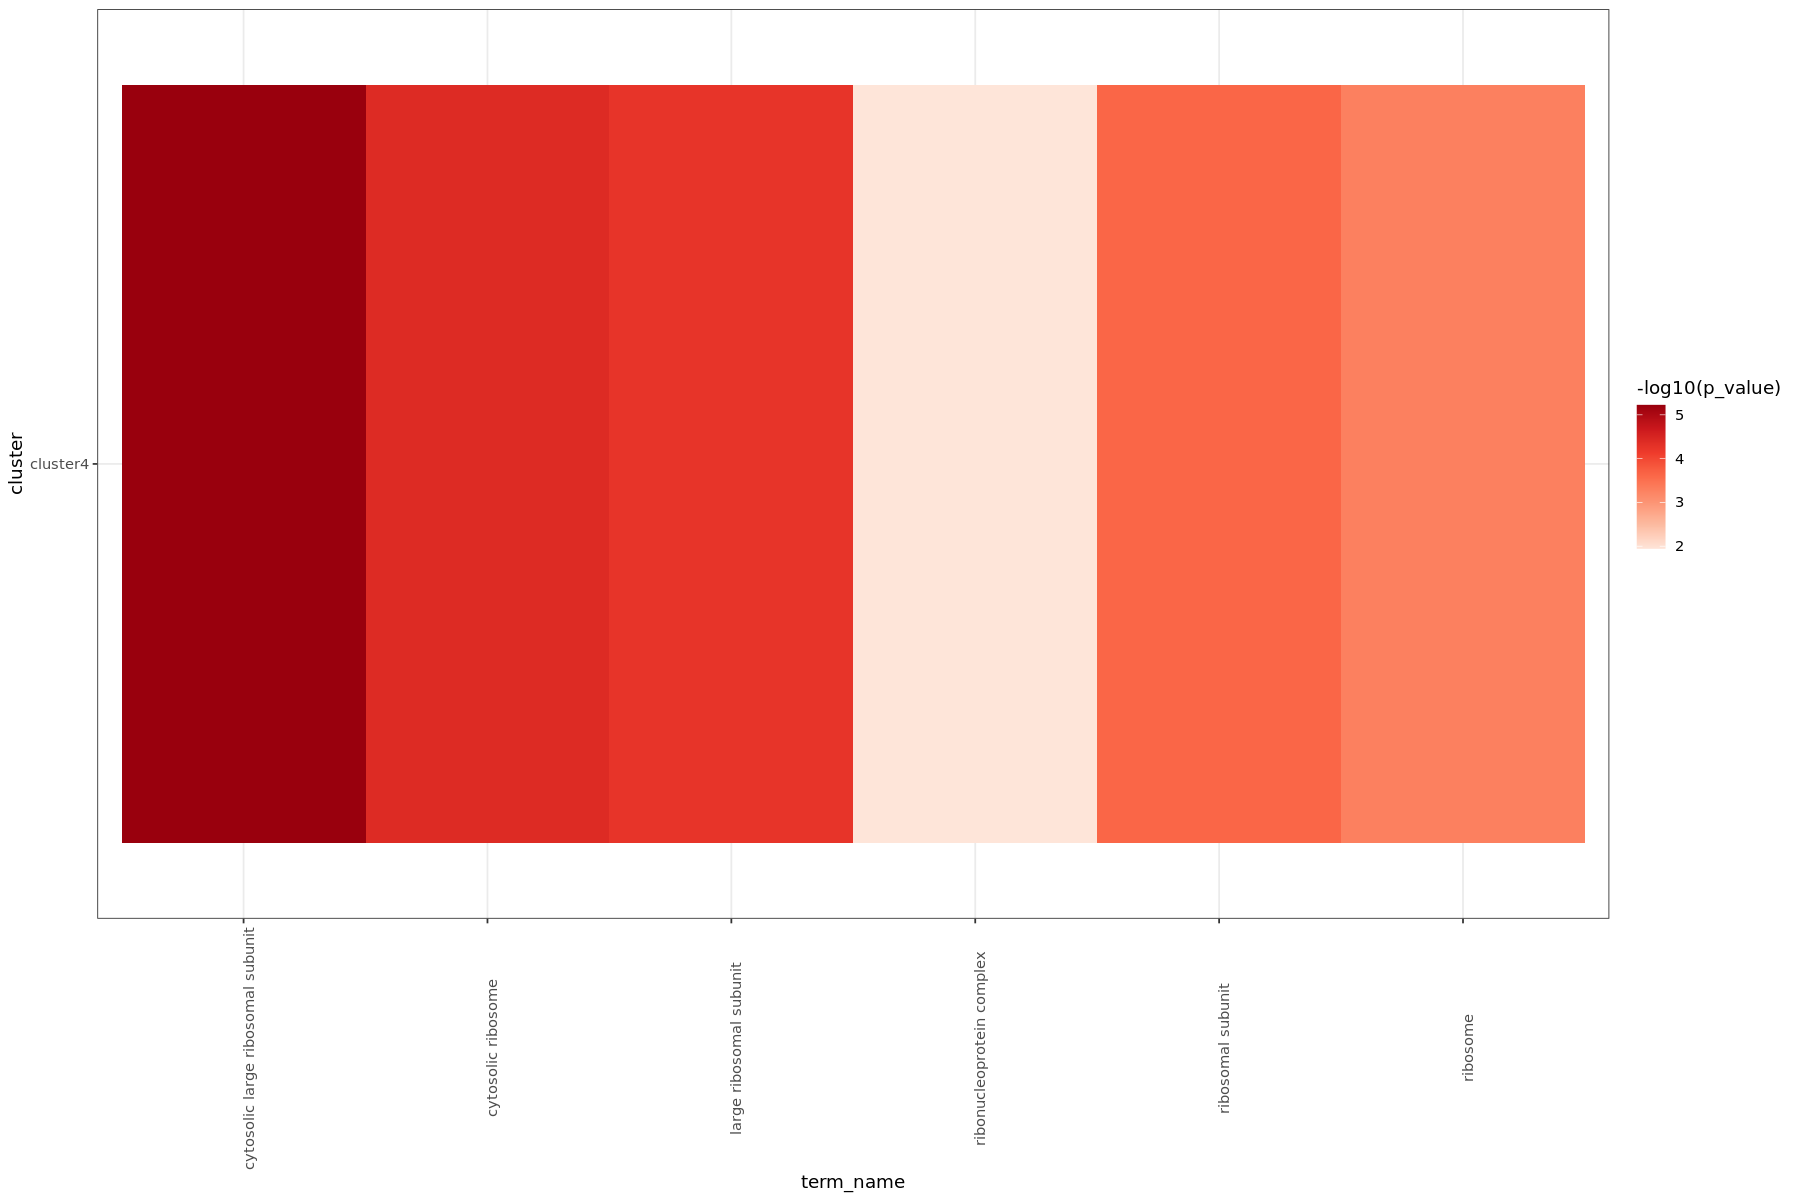

In [88]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(df_to_plot, aes(x=term_name, y=cluster, fill = -log10(p_value))) + geom_tile() + 
    theme_bw() + theme(axis.text.x = element_text(angle = 90)) + 
    scale_fill_gradientn(colors = brewer.pal(7,"Reds"))

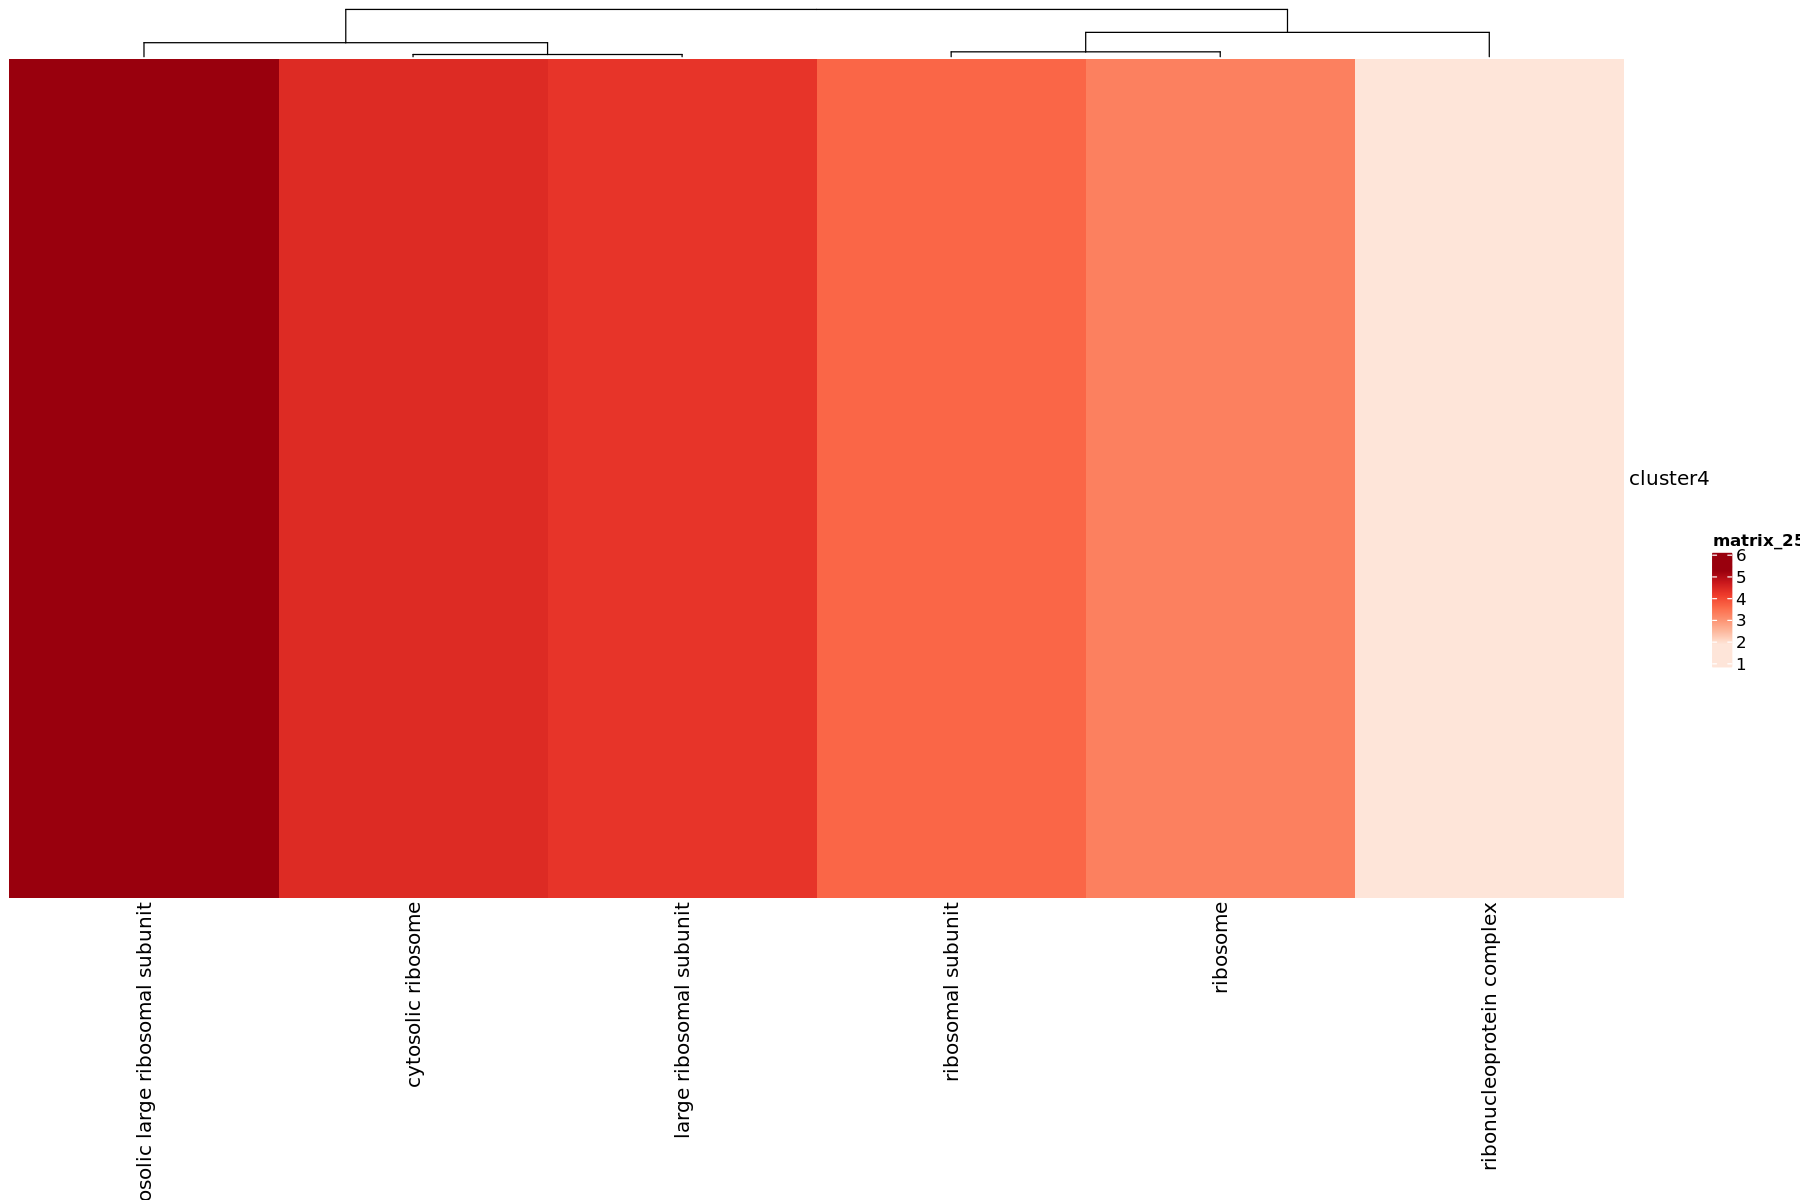

In [89]:
df_to_plot$cluster = as.character(df_to_plot$cluster)
df_to_plot$term_name = as.character(df_to_plot$term_name)
mat = matrix(0, nrow=length(unique(df_to_plot$cluster)), ncol=length(unique(df_to_plot$term_name)))
for (i in 1:nrow(mat)){
    cluster = unique(df_to_plot$cluster)[i]
    for (j in 1:ncol(mat)){
        term = unique(df_to_plot$term_name)[j]
#         print(term)
        if (length(df_to_plot[df_to_plot$cluster == cluster & df_to_plot$term_name == term,"p_value"]) == 0){next}
        mat[i,j] = min(df_to_plot[df_to_plot$cluster == cluster & df_to_plot$term_name == term,"p_value"])
    }
}
rownames(mat) = unique(df_to_plot$cluster)
colnames(mat) = unique(df_to_plot$term_name)
mat0 = -log10(mat)
mat0[mat0==Inf] = -1
Heatmap(mat0, col = brewer.pal(7,"Reds"))

In [74]:
########### Genes either positively or negatively correlated with cluster summary profiles

In [80]:
df_list = list()
for (i in 1:ncol(df)){
    gene_list = df[,i]
    names(gene_list) = rownames(df)
    # get positively correlated genes
    genes_pos = gene_list[gene_list>0.4]
    # AND negatively correlated genes
    genes_neg = gene_list[gene_list<(-0.4)]
    genes_corr = c(genes_pos, genes_neg)
    genes_corr = abs(genes_corr)
    if (length(genes_corr)==0){next}
    # order
    genes_corr = genes_corr[order(genes_corr,decreasing=TRUE)]
    # get gene names only
    genes = gsub(".*_","",names(genes_corr))
    # run gprofiler
    gres = gost(query=genes, organism = "hsapiens", ordered_query = TRUE, significant=FALSE, source = "GO:CC")
    df_list[[i]] = as.data.frame(gres$result)
}

In [81]:
pats = c()
for (i in 1:length(df_list)){
    if (is.null(df_list[[i]])){next}
    df_curr = as.data.frame(df_list[[i]])
    df_curr = df_curr[df_curr$p_value < 0.05,]
#     print(nrow(df_curr))
    n = min(10, nrow(df_curr))
    pats = c(pats, unique(df_curr[1:n,"term_name"]))
}
length(pats)

[1] 10

In [82]:
df_to_plot = data.frame()
for (i in 1:length(df_list)){
#     print(i)
    cluster = gsub("corr_","",colnames(df)[i])
    df_curr = df_list[[i]]
    
    if (is.null(df_curr)){next}
    df_curr$cluster = cluster
    df_to_plot = rbind(df_to_plot, df_curr[df_curr$term_name %in% pats,
                                           c("p_value","cluster","term_name","term_id")])
}
unique(df_to_plot$cluster)
# df_to_plot$cluster <- factor(df_to_plot$cluster, 
#                              levels = c("cluster12", "cluster0", "cluster1", "cluster5", "cluster8",
#                                         "cluster9", "cluster11", "cluster2", "cluster10", "cluster3",
#                                         "cluster6", "cluster7", "cluster4"))

[1] "cluster4"

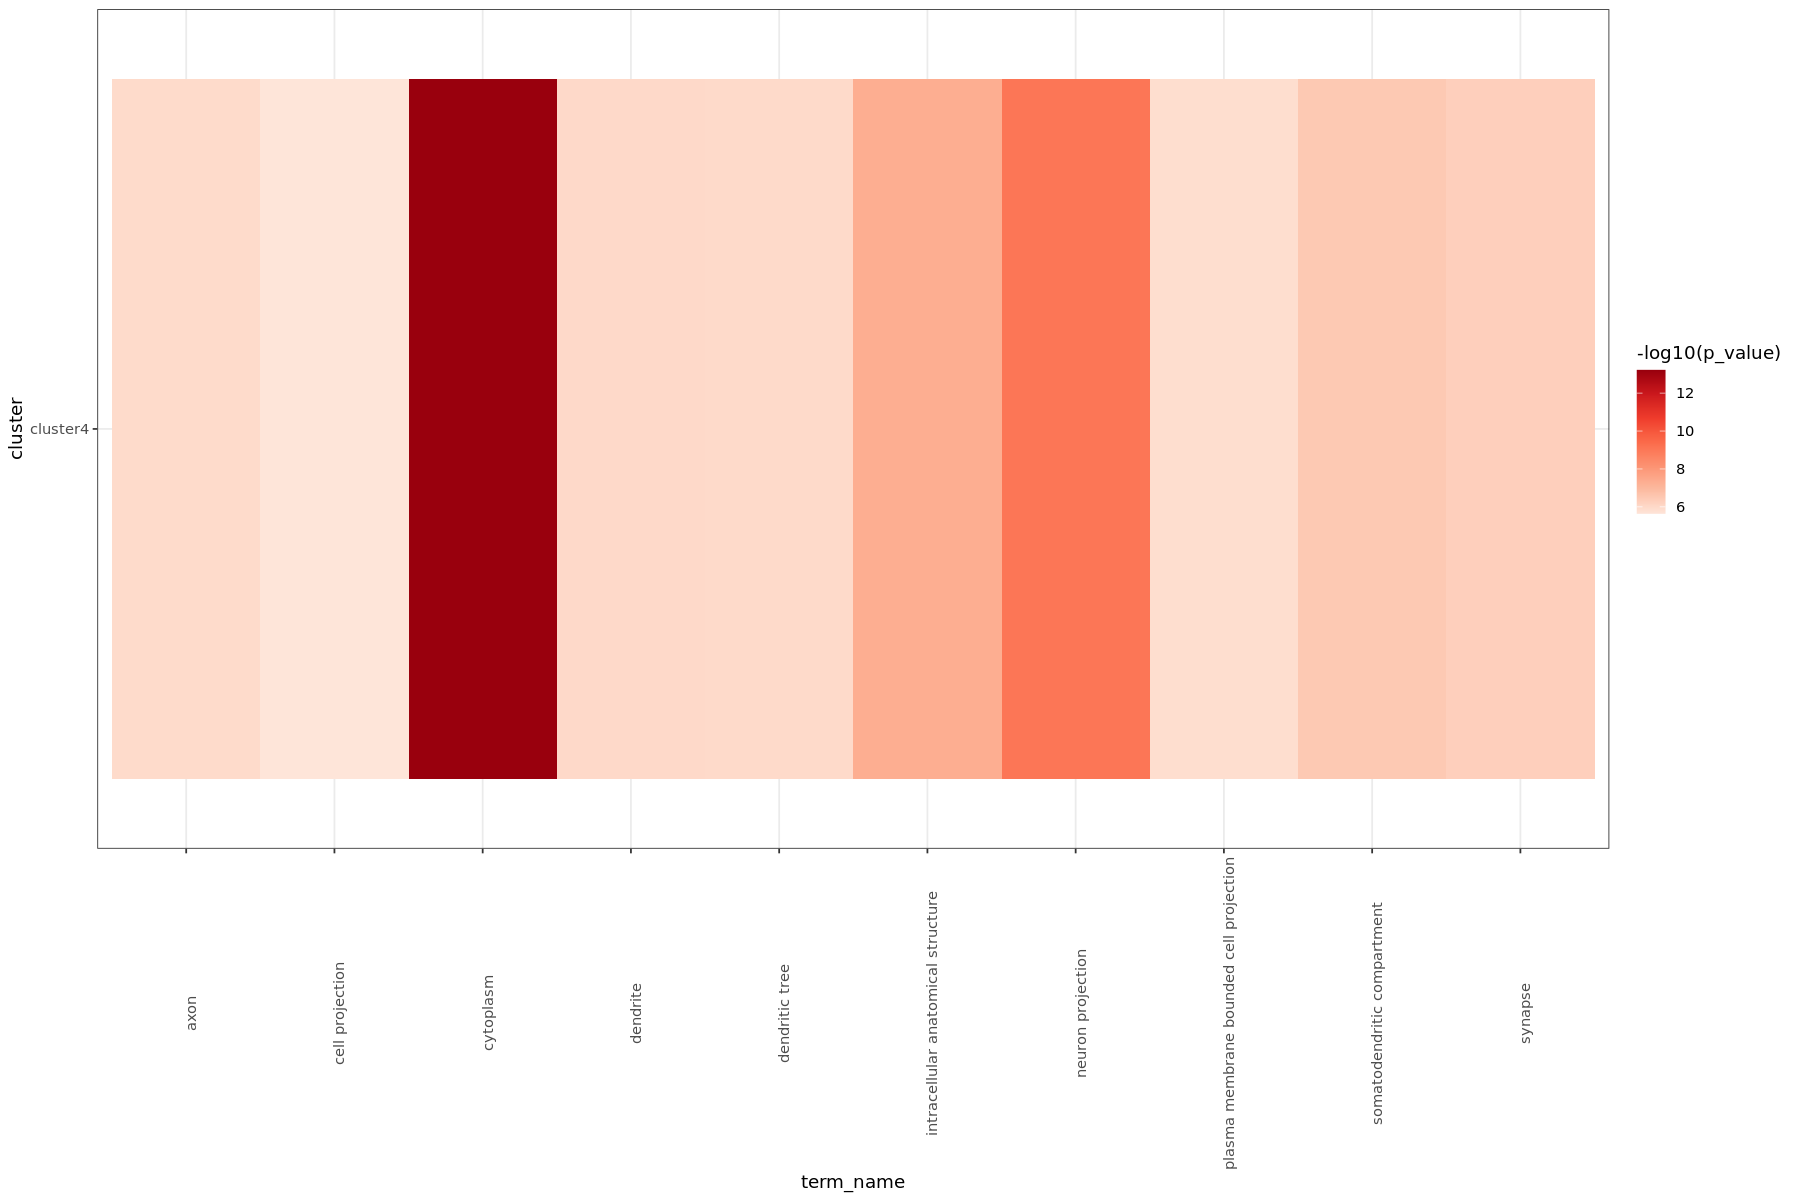

In [83]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(df_to_plot, aes(x=term_name, y=cluster, fill = -log10(p_value))) + geom_tile() + 
    theme_bw() + theme(axis.text.x = element_text(angle = 90)) + 
    scale_fill_gradientn(colors = brewer.pal(7,"Reds"))

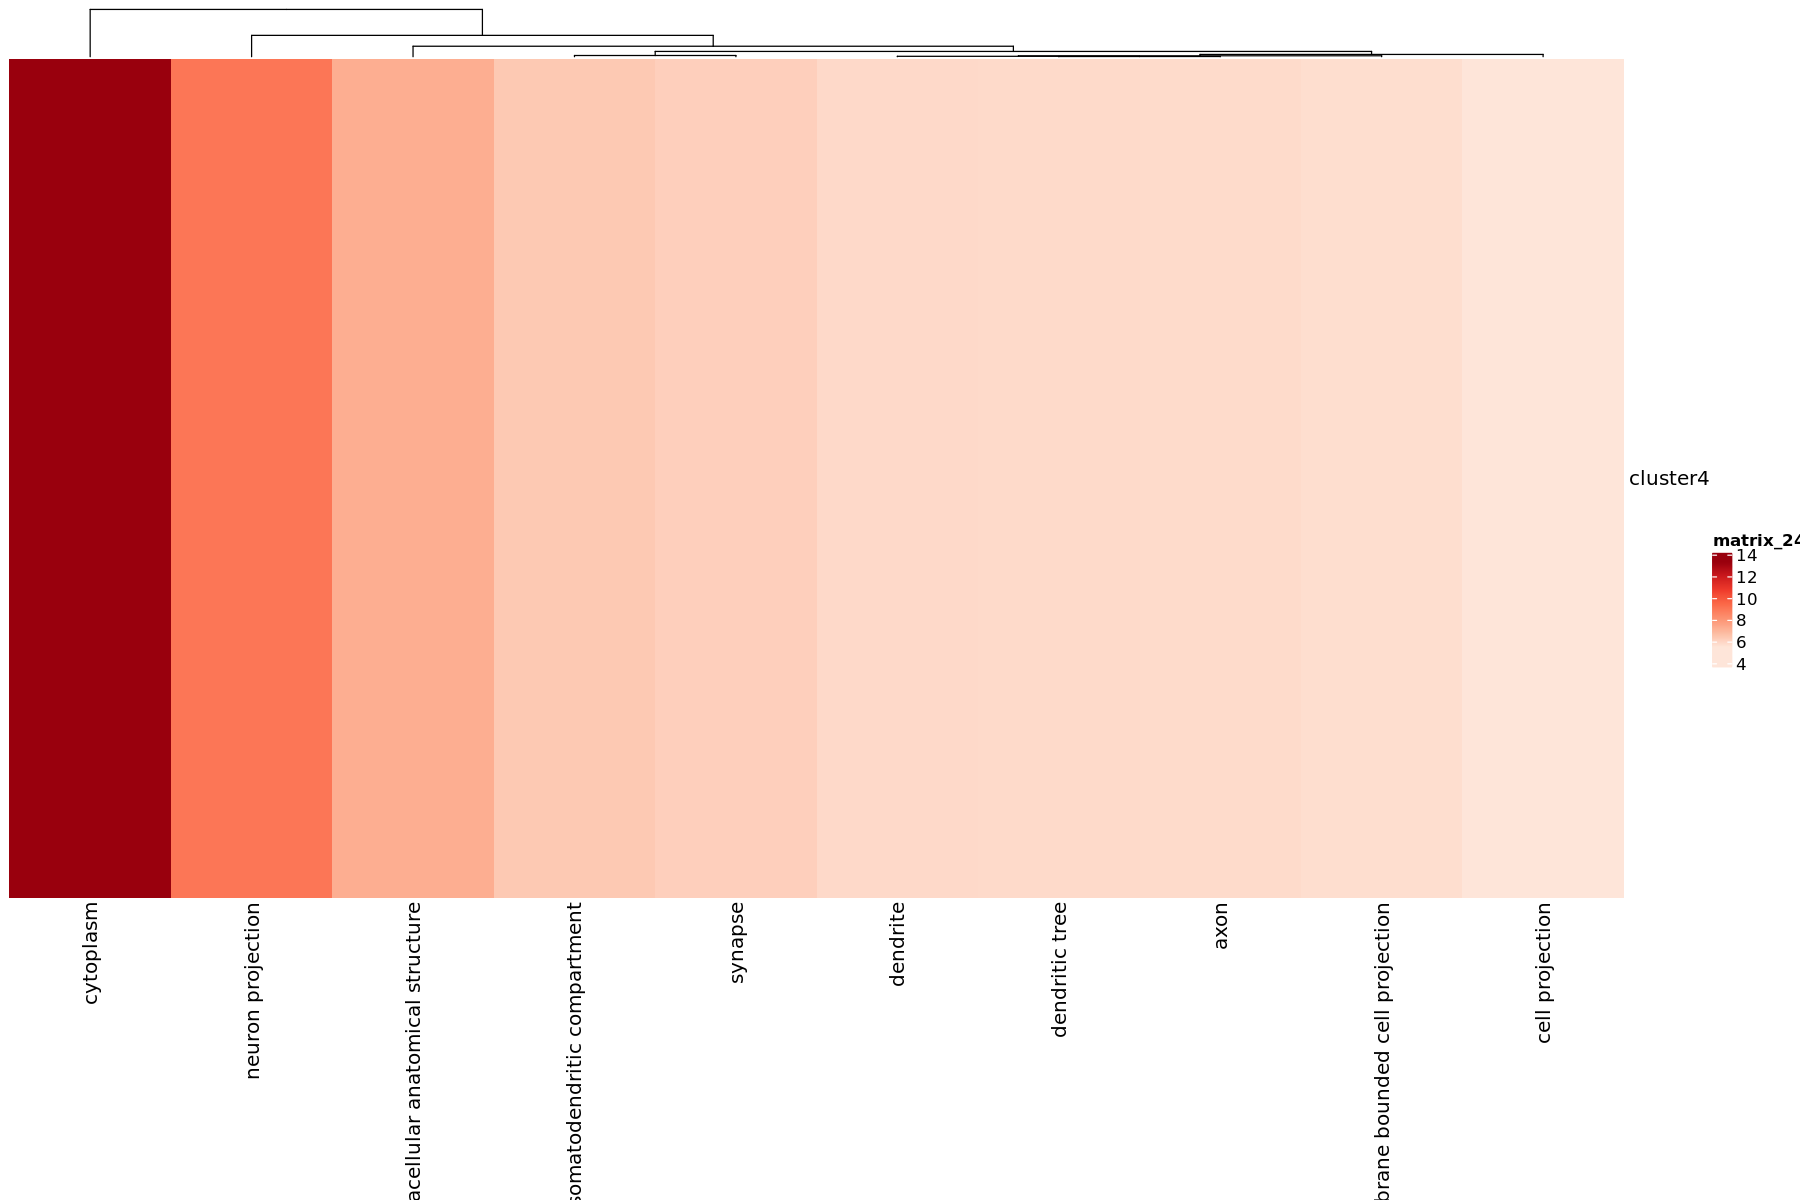

In [84]:
df_to_plot$cluster = as.character(df_to_plot$cluster)
df_to_plot$term_name = as.character(df_to_plot$term_name)
mat = matrix(0, nrow=length(unique(df_to_plot$cluster)), ncol=length(unique(df_to_plot$term_name)))
for (i in 1:nrow(mat)){
    cluster = unique(df_to_plot$cluster)[i]
    for (j in 1:ncol(mat)){
        term = unique(df_to_plot$term_name)[j]
#         print(term)
        if (length(df_to_plot[df_to_plot$cluster == cluster & df_to_plot$term_name == term,"p_value"]) == 0){next}
        mat[i,j] = min(df_to_plot[df_to_plot$cluster == cluster & df_to_plot$term_name == term,"p_value"])
    }
}
rownames(mat) = unique(df_to_plot$cluster)
colnames(mat) = unique(df_to_plot$term_name)
mat0 = -log10(mat)
mat0[mat0==Inf] = -1
Heatmap(mat0, col = brewer.pal(7,"Reds"))